# Formulations of Vector Autoregression

The standard definition of a the autoregressive model VAR($p$) is:


$$
    \bm{y}_t = \bm{\nu} + A_1 \bm{y}_{t-1} + \cdots + A_p \bm{y}_{t-p} + \bm{u}_t \quad
$$

where $t \in \mathbb{Z}$, $\bm{y}$ is a length $K$ random vector,
$\bm{\nu}$ is a fixed length $K$ vector, the $A_i$ are $K \times K$
constant coefficient matrices and $\bm{u}_t$ is a white noise
or innovation process with $E(\bm{u}_t) = \bm{0}$, 
$E(\bm{u}_t \bm{u}_t^T) = \Sigma_{\bm{u}}$ with 
$\Sigma_{\bm{u}}$ assumed non-singular, and 
$E(\bm{u}_t \bm{u}_s^T) = \bm{0}$ when $s \neq t$.

Since every VAR($p$) process can be expressed as a VAR(1) process, we will simplify the above expression.

$$
\bm{y}_t = \bm{\nu} + A \bm{y}_{t-1} + \bm{u}_t \quad (1)
$$

We can simulate this system by providing an initial condition $\bm{y}_0$, then at each timestep, taking a draw from a multivariate normal distribution to simulate a realization of $\bm{u}_t$.

We can also derive an alternate formulation by applying this expression to itself recursively.

$$
\bm{y}_t = \bm{\nu} + A \bm{y}_{t-1} + \bm{u}_t \\
\bm{y}_t = \bm{\nu} + A \big(\bm{\nu} + A \bm{y}_{t-2} + \bm{u}_{t-1} \big) + \bm{u}_t \\
\vdots \\
\bm{y}_t = (I + A + A^2 + \cdots + A^m) \bm{\nu} + A^{m+1} \bm{y}_{t - (m+1)} + \sum_{i = 0}^m A^i \, \bm{u}_{t - i}.


$$

If the modulus of the largest eigenvalue of $A$ is less than one, then $||A^m|| \rightarrow 0$ as $m \rightarrow \infty$ so $A^{m+1}y_{t - (m+1)} \rightarrow 0$ and the series 
$$
I + A + A^2 + \cdots = (I - A)^{-1}
$$

Thus we have
$$
\bm{y}_t = \bm{\mu} + \sum_{i=0}^{\infty}A^i \bm{u}_{t - i} \quad (2)
$$

where $\bm{\mu} = (I - A)^{-1}\bm{\nu}$.

To better understand how these formulations work and what they mean, we will attempt to show how the different formulations produce the same time series.

We will approximate $\bm{y}_t$ with $\hat{\bm{y}}_t$
$$
\hat{\bm{y}}_t = \bm{\mu} + \sum_{i=0}^{M}A^i\bm{u}_{t-i} \\
\hat{\bm{y}}_t = \bm{\mu} + \bm{u}_t + A \bm{u}_{t - 1} + \cdots + A^{M} \bm{u}_{t-M}
$$

To compute $\hat{\bm{y}}_t$ we need the a sequence of realizations of $\bm{u}_t$, $\bm{u}_{t-1}$, ..., $\bm{u}_{t-M}$. We can aquire this by sampling from a multivariate normal with zero mean and covariance $\Sigma_{\bm{u}}$

For the next timestep, $t+1$, we know 
$$\hat{\bm{y}}_{t+1} = \bm{\mu} + \bm{u}_{t+1} + A \bm{u}_{t} + \cdots + A^{M} \bm{u}_{t+1 -M}.
$$
Since  $\hat{\bm{y}}_{t+1}$ depends on all terms of the previous sequence $\bm{u}_t$, $\bm{u}_{t-1}$, ..., $\bm{u}_{t + 1- M}$, $\bm{u}_{t-M}$ except the last, $\bm{u}_{t-M}$. 

It only requires one new value to be generated: $\bm{u}_{t+1}$.

Thus, after generating the first $M$ random vectors, we can proceed by only generating one random vector each iteration.

## Simulating with Formulation (2)

#### Function for Simulation

In [3]:
def rescale_spec_rad(A, desired_spect_rad):
    # Rescale the largest eigenvalue of A so `spec_rad(A)== desired_spect_rad`
    spect_rad = np.max(np.abs(np.linalg.eigvals(A)))
    scaledA = A * desired_spect_rad / spect_rad
    return scaledA

def var_sim_form2(mu, A, cov, max_A_pow=15, timesteps=200):

    process_dim = A.shape[0]
    zero_mean = np.zeros(process_dim)

    # To store the timeseries
    y = np.zeros((timesteps, process_dim))

    # To store powers of A
    Apows = [np.eye(process_dim)]

    # To store white noise
    white_noise_vecs = [np.random.multivariate_normal(zero_mean, cov)]

    # Initialized powers of A and white noise vectors
    for i in range(max_A_pow):
        Apows.append(A @ Apows[-1])
        white_noise_vecs.append(np.random.multivariate_normal(zero_mean, cov))
    
    # Simulate timesteps
    for t in range(timesteps):
        # Grab the `max_A_pow + 1` most recent noise vectors
        noise_vec_reverse = white_noise_vecs[:max_A_pow:-1]
        # Weight them by the appropriate powers of A
        weighted_noise = [Ai @ u for Ai, u in zip(Apows, noise_vec_reverse)]
        # Sum them all together
        weighted_noise_sum = np.sum(weighted_noise, axis=0)
        # Assign to y_t
        y[t, :] = mu + weighted_noise_sum
        # New white noise vector
        white_noise_vecs.append(np.random.multivariate_normal(zero_mean, cov))


    return y, white_noise_vecs

||A||^(max_power) approx equal to 0.20589113209464907


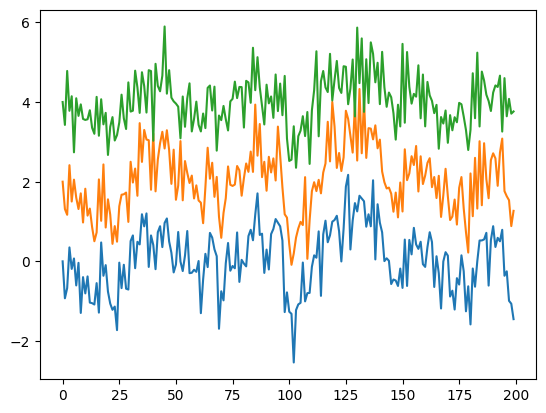

In [4]:
A = np.array([
    [0.0, 1.0, 1.0],
    [1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
])
# Desired spectral radius of A (largest eigenvalue modulus)
desired_spect_rad = .9
A = rescale_spec_rad(A, desired_spect_rad)


# mu vector
mu = np.array([0.0, 2, 4])


# Covariance of white noise
cov = .2 * np.array([
    [1., 0.5, 0.0],
    [0.5,  1., 0.0],
    [0.0, 0.0, 1.0],
])

# Maximum power of A
max_A_pow = 15

print(f"||A||^(max_power) approx equal to {desired_spect_rad**max_A_pow}")

Yform2, U = var_sim_form2(mu, A, cov, max_A_pow=max_A_pow)
plt.plot(Yform2)
plt.show()

## Simulating with Formulation (1)

We will generate the same time series using the noise vectors from the previous simulation

In [5]:
def var_sim_form1(nu, A, cov, y0, noise_vecs, timesteps=200):
    process_dim = A.shape[0]
    Y = np.zeros((timesteps, process_dim))
    Y[0, :] = y0
    for t in range(timesteps - 1):
        Y[t+1, :] = nu + A @ Y[t, :] + noise_vecs[t]
    return Y


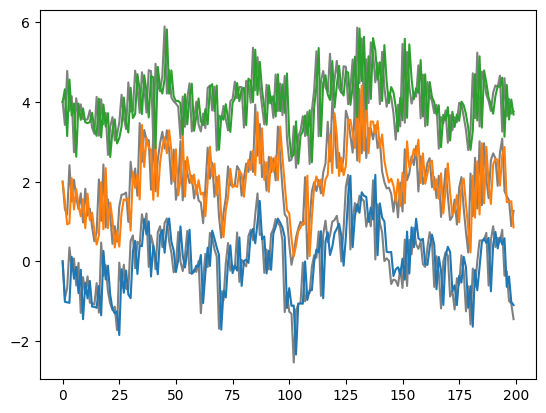

In [6]:
# translate mu vector to nu vector
nu = (np.eye(A.shape[0]) - A) @ mu
# Collect the necessary noise vectors
noise_vecs = U[max_A_pow:]
# Initial condition taken from the previous
y0 = Yform2[0, :]

Yform1 = var_sim_form1(nu, A, cov, y0, noise_vecs)

plt.plot(Yform2, color="gray")
plt.plot(Yform1)
plt.show()

#### Error in approximation over time

[]

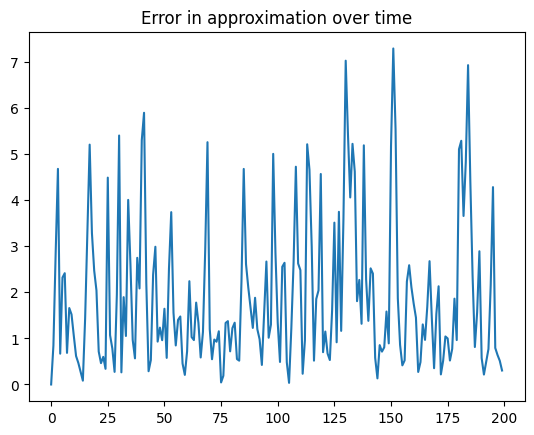

In [7]:
error = np.sum((Yform1 - Yform2)**2, axis=1)
plt.plot(error)
plt.title("Error in approximation over time")
plt.plot()

## Decompositions of the simulated signals

Plot error and signal in the direction of the dominant eigenvector and on the other two modes.

We have two signals, $\{\mathbf{y}_t\}_{t=0}^{200}$ and $\{\hat{\mathbf{y}}_t\}_{t=0}^{200}$. Each $\bm{y}_t$ is generated using the following difference equation
$$
    \bm{y}_t = \bm{\nu} + A \bm{y}_{t-1} + \bm{u}_t
$$

by starting with initial condition $\bm{y}_0$  and drawing realizations of $\bm{u}_t$ from a zero mean multivariate normal distribution with covariance matrix $\Sigma_{\bm{u}}$.

Since an equivalent description of $\bm{y}_t$ is
$$
\bm{y}_t = \bm{\mu} + \sum_{i=0}^{\infty}A^i \bm{u}_{t - i} \quad (2)
$$

we can truncate this infinite series to obtain an approximation,
$$
\hat{\bm{y}}_t = \bm{\mu} + \bm{u}_t + A \bm{u}_{t - 1} + \cdots + A^{M} \bm{u}_{t-M}
$$

Thus, we can write the error at each timestep as
$$
\bm{e}_t = \bm{y}_t - \hat{\bm{y}}_t = \sum_{i=M+1}^\infty A^i \bm{u}_{t-i}
$$

Solving for the first two moments gives:

$$
E[\bm{e}_t] = E\Big[\sum_{i=M+1}^\infty A^i \bm{u}_{t-i}\Big] = \sum_{i=M+1}^\infty A^i E[\bm{u}_{t-i}] = \bm{0}
$$

$$
\text{Cov}[\bm{e}_t, \bm{e}_s] = E[\bm{e}_T^T \bm{e}_s]
= E\Big[\Big(\sum_{i=M+1}^\infty A^i \bm{u}_{t-i}\Big)^T \Big(\sum_{i=M+1}^\infty A^i \bm{u}_{t-i}\Big)\Big] \\
= E\Big[\sum_{i=M+1}^\infty \sum_{j=M+1}^\infty \bm{u}_{t-i}^T (A^i)^T A^j \bm{u}_{t-j}\Big] \\
= \sum_{i=M+1}^\infty \sum_{j=M+1}^\infty E\Big[\bm{u}_{t-i}^T (A^i)^T A^j \bm{u}_{t-j}\Big]
$$

At this point, there isn't much we can do to simplify. There might be a [theorem about the distribution of a quadratic form of a gaussian vector](https://epubs.siam.org/doi/abs/10.1137/1133084?journalCode=tprbau) that we could apply.

Instead we can use the fact that $||A^i|| \leq \rho^i$ where $\rho$ is the spectral radius of $A$. Therefore, in the series definition of the covariance of the error, each successive term is decreasing in size by a factor of $\rho^2$.

It makes sense to approximate the covariance of the error with just the first terms. Actually, nevermind. It is a double sum, so the smallest powers of $A$ appear infinitely many times. 

By exploring the eigen decomposition of a symmetric $A$ as it relates to the error, we find:
$$
\bm{e}_t = \sum_{i=M+1}^\infty A^i \bm{u}_{t-i} \\
= \sum_{i=M+1}^\infty (\lambda_1^i \bm{v}_1\bm{v}_1^T + \cdots + \lambda_n^i \bm{v}_n \bm{v}_n^T ) \bm{u}_{t-i} \\
= \sum_{k=1}^n \sum_{i=M+1}^\infty \lambda_k^i \bm{v}_k \bm{v}_k^T \bm{u}_{t-i} \\
= \sum_{k=1}^n \bm{v}_k \bm{v}_k^T  \sum_{i=M+1}^\infty \lambda_k^i \bm{u}_{t-i} \\
$$

This says that we can write the error as the projection of scaled sum of the noise vectors onto the eigenvectors of A. Since we assumed $A$ was symmetric, the eigenvalues are all real and successively smaller.

We can project the error onto each of the eigenspaces to see the magnitude of the error in the direction of each eigenvector:

$$
\bm{v}_j \bm{v}_j^T \bm{e} = \bm{v}_j \bm{v}_j^T \sum_{k=1}^n \bm{v}_k \bm{v}_k^T  \sum_{i=M+1}^\infty \lambda_k^i \bm{u}_{t-i} \\
= \sum_{k=1}^n \bm{v}_j\bm{v}_j^T  \bm{v}_k \bm{v}_k^T  \sum_{i=M+1}^\infty \lambda_k^i \bm{u}_{t-i} \\
= \bm{v}_j \bm{v}_j^T  \bm{v}_j \bm{v}_j^T  \sum_{i=M+1}^\infty \lambda_j^i \bm{u}_{t-i} \\
= \bm{v}_j \bm{v}_j^T \sum_{i=M+1}^\infty \lambda_j^i \bm{u}_{t-i} \\
=  \sum_{i=M+1}^\infty \lambda_j^i \bm{v}_j \bm{v}_j^T \bm{u}_{t-i} \\
$$

We can see that this translates directly to the projection of each noise vector onto the corresponding eigenspace.

It's possible that the covariance of the noise vectors, $\Sigma_{\bm{u}}$ could impact the magnitude of the error here. However, given that we already assumed that $A$ is symmetric, which will never be true in practice and we are investigating the error of an approximation which we will never use, it's probably not worth diving into it further.

However, it does seem interesting to plot the projection of the error onto the eigenspaces:

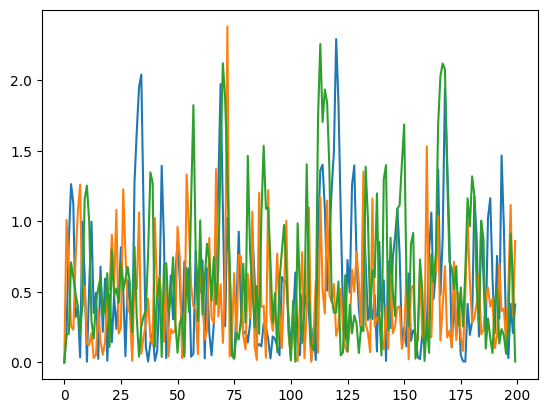

array([0.54144498, 0.44467463, 0.63283303])

In [23]:
# Make a symmetric A matrix
A = np.array([
    [0.0, 1.0, 1.0],
    [1.0, 0.0, 1.0],
    [1.0, 1.0, 0.0],
])

# Rescale spectral radius of symmetric A
desired_spect_rad = .9
A = rescale_spec_rad(A, desired_spect_rad)


# mu vector
mu = np.array([0.0, 2, 4])


# Covariance of white noise
cov = .2 * np.array([
    [1., 0.5, 0.0],
    [0.5,  1., 0.0],
    [0.0, 0.0, 1.0],
])

# Truncated noise sum solution
Yform2, U = var_sim_form2(mu, A, cov, max_A_pow=max_A_pow)

# translate mu vector to nu vector
nu = (np.eye(A.shape[0]) - A) @ mu
# Collect the necessary noise vectors
noise_vecs = U[max_A_pow:]
# Initial condition taken from the previous
y0 = Yform2[0, :]

# Difference relation solution
Yform1 = var_sim_form1(nu, A, cov, y0, noise_vecs)

# Error vectors
error = Yform1 - Yform2

eigvals, eigvecs = np.linalg.eig(A)

# Because the eigenvectors are unit length we can compute the norm
# of the projection of the error onto the eigenvectors
# by taking the absolute value of the dot product of the error 
# with each eigenvector.

# Because the eigenvectors are columns, we transpose the matrix
# and matrix multiply with each error vector

error_proj = np.abs(eigvecs.T @ error.T)

plt.plot(error_proj.T)
plt.show()

np.mean(error_proj, axis=1)



This doesn't exhibit the spit in size predicted by the theory. It's possible I made a mistake.